In [2]:
import sys
sys.path.append('./code')

from colorama import Fore, Back
# from flask import session
# from pyqum import get_db, close_db
from json import dumps
#---------------load package of load_data---------------
from LoadData_lab import jobid_search_pyqum, pyqum_load_data
#---------------load package of cavity search---------------
from CavitySearch import make_amp,make_pha,input_process,output_process,true_alt_info,find_best_ans,db_datamaker,Find_eps,dbscan,predict_dataset,compa_gru_db
from numpy import array,vstack, hstack
from pandas import Series, DataFrame, concat
from keras.models import load_model
from QubitFrequency import colect_cluster,cal_nopecenter,cal_distance,denoise,check_overpower,find_farest,cal_Ec_GHz,freq2idx
#---------------load package of power dependent---------------
from sklearn.cluster import KMeans
from numpy import median
from PowerDepend import loadmat_valid,outlier_detect, cloc
#---------------load package of flux dependent---------------
from FluxDepend import flux_load_data, fit_sin
#---------------save jobid list in pickle---------------
from pickle import dump,load
#---------------process---------------
from numpy import mean
# from pyqum.directive.characterize import F_Response, CW_Sweep
from random import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

class Load_From_pyqum:
    def __init__(self, jobid):
        self.jobid = jobid
        # self.pyqum_path, self.task = jobid_search_pyqum(self.jobid)
        # self.pyqum_path = 'data/F_Response.pyqum(2)'
        if jobid ==5094:
            self.pyqum_path = r"C:\Users\tsung\Downloads\5094.pyqum(10)"
        if jobid ==5105:
            self.pyqum_path = r"C:\Users\tsung\Downloads\5105.pyqum(11)"
        if jobid ==5097:
            self.pyqum_path = r"C:\Users\tsung\Downloads\5097.pyqum(3)"
    def load(self):
        self.amp_data,self.jobid_check  = pyqum_load_data(self.pyqum_path)
        if self.jobid == self.jobid_check:
            print("JOBid ",self.jobid," checked")
        return self.amp_data
            
class CavitySearch:
    def __init__(self, dataframe):
        self.dataframe = dataframe

        # ans of prediction
        self.answer = {}
        self.amplitude, self.phase, self.freq = [], [], []
        self.fig = DataFrame()
        self.ans_array = {}

    def do_analysis(self,designed):
        I = self.dataframe['I']
        Q = self.dataframe['Q']
        self.freq = self.dataframe['Frequency']

        self.amplitude = make_amp(I,Q)
        self.phase = make_pha(I,Q)
        self.fig = DataFrame(concat([Series(self.freq),Series(self.amplitude),Series(self.phase)],axis=1))

        # GRU part
        AMP = load_model('./model/GRU_AMP_Accuracy_ 96.63_.h5')
        PHA = load_model('./model/GRU_PHA_Accuracy_ 95.01_.h5')

        amp, pha, comparison = input_process(self.fig)      # frequency,amplitude,phase; comparison[no.][0] for freq start, end for comparison[no.][1] 
        self.fig.columns = ['<b>frequency(GHz)</b>','Amplitude','UPhase']

        # prediction GRU
        amp_pred = AMP.predict(amp)
        pha_pred = PHA.predict(pha)

        # result process
        true_out ,alt = output_process(amp_pred,pha_pred,comparison)  
        zone, voted_amp, voted_pha = true_alt_info(true_out,alt,self.fig)

        gru_ans_amp, status_amp = find_best_ans(zone,voted_amp,self.fig,designed)  # status is the origin predict result with the default peak_limit = 8
        gru_ans_pha, status_pha = find_best_ans(zone,voted_pha,self.fig,designed)
        
        # DBSCAN part
        # dbscan for phase
        inp_db = db_datamaker(self.phase,self.freq)
        eps,mini = Find_eps(inp_db) 
        l_d_pha = dbscan(inp_db,eps,mini)
        ture_out_db_pha = predict_dataset(l_d_pha,self.freq)

        # dbscan for amplitude
        inp_db = db_datamaker(self.amplitude,self.freq)
        eps,mini = Find_eps(inp_db) 
        l_d_amp = dbscan(inp_db,eps,mini)
        ture_out_db_amp = predict_dataset(l_d_amp,self.freq)

        true_out_db = vstack((ture_out_db_amp,ture_out_db_pha))

        zone, voted_amp, voted_pha = true_alt_info(true_out_db,alt,self.fig)
        db_ans_amp, status_amp = find_best_ans(zone, voted_amp, self.fig, designed)
        db_ans_pha, status_pha = find_best_ans(zone, voted_pha, self.fig, designed)

        amp_ans = [gru_ans_amp,db_ans_amp]
        pha_ans = [gru_ans_pha,db_ans_pha]

        self.answer = compa_gru_db(amp_ans,pha_ans)   # answer looks: {'0':[start,end],'1':[...],...}
        return self.answer

    def give_answer_array(self,no):
        self.ans_array = {
        'Frequency':self.fig[self.fig["<b>frequency(GHz)</b>"].between(self.answer[str(no)][0],self.answer[str(no)][1])]['<b>frequency(GHz)</b>'],
        'Amplitude':self.fig[self.fig["<b>frequency(GHz)</b>"].between(self.answer[str(no)][0],self.answer[str(no)][1])]['Amplitude'],
        'UPhase':self.fig[self.fig["<b>frequency(GHz)</b>"].between(self.answer[str(no)][0],self.answer[str(no)][1])]['UPhase']
        }

class PowerDepend:
    def __init__(self, dataframe):
        self.data = loadmat_valid(dataframe)
    def do_analysis(self):
        model = KMeans(n_clusters=2, n_init=1, random_state=0)
        label = model.fit_predict(self.data)
        label_new = outlier_detect(self.data,label)
        power_0,power_1 = cloc(label_new)
        print("power : "+"{:.2f}".format(self.data[:, 0][power_0])+"{:<7}".format(' dBm ; ')+
            "fr : "+"{:.2f}".format(self.data[:, 1][power_0])+"{:<7}".format(' MHz ; \n')+
            "power : "+"{:.2f}".format(self.data[:, 0][power_1])+"{:<7}".format(' dBm ; ')+
            "fr : "+"{:.2f}".format(self.data[:, 1][power_1])+"{:<7}".format(' MHz ; '))
        self.select_power = min(self.data[:, 0][power_0],self.data[:, 0][power_1])
        return self.select_power
        
class FluxDepend:
    def __init__(self, dataframe):
        self.dataframe = dataframe
    def do_analysis(self,f_bare):
        tol = 0.1
        self.valid = flux_load_data(self.dataframe)
        self.valid = self.valid.drop(self.valid[(self.valid['fr']<f_bare+tol) & (self.valid['fr']>f_bare-tol)].index)
        ki = self.valid['fr']-f_bare
        f_qubit = f_bare-1/ki
        offset = self.valid['flux'][f_qubit ==f_qubit.max()]
        f_dress = self.valid['fr'][offset.index]
        res = fit_sin(self.valid['flux'],f_qubit)
        period = float(res['period'])
        print("{:<36}".format("Final_dressed cavity frquency"), " : " , "{:>8.2f}".format(float(f_dress)) ,"MHz")
        print("{:<36}".format("Final_bare cavity frquency"), " : " , "{:>8.2f}".format(float(f_bare)) ,"MHz")
        print("{:<36}".format("Final_dressed cavity frquency diff."), " : " , "{:>8.2f}".format(float(f_dress-f_bare)) ,"MHz")
        print("{:<36}".format("Final_offset")," : ","{:>8.2f}".format(float(offset)),"uA")
        print("{:<36}".format("Final_period")," : ","{:>8.2f}".format(float(period)),"uA")
    #     if plot:
    #         import matplotlib.pyplot as plt
    #         from numpy import linspace
    #         plt.rcParams["figure.figsize"] = [20,10]
    #         plt.subplot(211)
    #         plt.scatter(self.valid['flux'],self.valid['fr'],color='black', marker='o',label='real data')
    #         plt.subplot(212)
    #         plt.scatter(self.valid['flux'],f_qubit,color='r', marker='*',label='f_qubit')
    #         x = linspace(self.valid['flux'].min(),self.valid['flux'].max(),200)
    #         plt.plot(x, res["fitfunc"](x), "r-", label="fit curve", linewidth=2)
    #         plt.xlabel("Flux : uA")
    #         plt.ylabel("Freq : MHz")
    #         # plt.ylim(self.valid['fr'].min()-.20,self.valid['fr'].max()+.20)
    #         plt.legend()
    #         plt.show()
        return {"f_dress":float(f_dress/1000),"f_bare":float(f_bare/1000),"f_diff":float((f_dress-f_bare)/1000),"offset":float(offset),"period":float(period)}
    
class QubitFreq_Scan:
    def __init__(self,dataframe):#,Ec,status,area_Maxratio,density
        self.dataframe = dataframe

        self.fq = 0.0
        self.Ec = 0.0
        self.freq = 0.0
        self.status = 0
        self.target_freq = []
        self.sub = []
        self.title = ''
        self.answer = {} # <- 0630 update
        self.plot_items = {}

    def do_analysis(self):
        self.freq = self.dataframe['Frequency'].to_numpy()  #for qubit  <b>XY-Frequency(GHz)</b>
        I = self.dataframe['I'].to_numpy()
        Q = self.dataframe['Q'].to_numpy()

        inp_db = []
        for i in range(I.shape[0]):
            inp_db.append(list(hstack(([I[i]],[Q[i]]))))

        # start DBSCAN
        eps,min_samples = Find_eps(inp_db)
        labels_db = dbscan(array(inp_db),eps,min_samples)

        # output process
        peak_susp_idx, nope_idx = colect_cluster(labels_db,mode='db')
        nope_center = cal_nopecenter(nope_idx,I,Q)

        # redefine the background
        redef_sub = []
        for i in range(self.freq.shape[0]):
            redef_sub.append(cal_distance([I[i],Q[i]],nope_center))

        self.sub = array(redef_sub)
        self.title = 'Amplitude_Redefined'


        if len(peak_susp_idx) != 0:

            tip = denoise(peak_susp_idx,self.freq,self.sub)
            #filter out the overpower case within +-0.5 std
            overpower,_,_ = check_overpower(tip,self.sub,0.5)

            if overpower == 'safe':
                #farest 3 point in IQ
                denoised_freq = find_farest(tip,nope_center,self.sub,I,Q,self.freq)

                #calculate Ec based on farest
                self.fq, self.Ec, self.status, self.target_freq = cal_Ec_GHz(denoised_freq,self.sub,self.freq)
            else:
                self.fq, self.Ec, self.status, self.target_freq = 0, 0, 0, []
        else:
            self.fq, self.Ec, self.status, self.target_freq = 0, 0, 0, []

        self.answer = {'Fq':self.fq,'Ec':self.Ec,'Status':self.status,'Freqs':self.target_freq} 
        '''status = 0 for 0 peak detected -> overpower with high probability
           status = 1 for 1 peak detected -> so far, a stronger xy-power again
           status = 2 for 2 peak detected'''
        return self.answer
                                                                                         
    def give_result(self):
        farest = freq2idx(self.target_freq,self.freq)[:3]
        self.plot_items = {
            'Targets':self.sub[farest],
            'Targets_Freq':self.freq[farest],
            'Sub_Frequency':self.freq,
            'Substrate':self.sub
        }

def char_fresp_new(sparam,freq,powa,flux,dcsweepch = "1",comment = "By bot"):
    # Check user's current queue status:
    if session['run_clearance']:
        print(comment)
        wday = int(-1)
        sparam = sparam   #S-Parameter
        ifb = "100"     #IF-Bandwidth (Hz)
        freq = freq #Frequency (GHz)
        powa = powa    #Power (dBm)
        fluxbias = flux   #Flux-Bias (V/A)
        comment = comment.replace("\"","") #comment
        PERIMETER = {"dcsweepch":dcsweepch, "z-idle":'{}', "sweep-config":'{"sweeprate":0.0001,"pulsewidth":1001e-3,"current":1}'} # DC=YOKO
        CORDER = {'Flux-Bias':fluxbias, 'S-Parameter':sparam, 'IF-Bandwidth':ifb, 'Power':powa, 'Frequency':freq}
        print(CORDER)
        # Start Running:
        # TOKEN = 'TOKEN(%s)%s' %(session['user_name'],random())
        workspace = F_Response(session['people'], corder=CORDER, comment=comment, tag='', dayindex=wday, perimeter=PERIMETER)
        return workspace.jobid_analysis
    else: return show()
def char_cwsweep_new(sparam,freq,powa,flux,f_bare,dcsweepch = "1",comment = "By bot"):
    # Check user's current queue status:
    if session['run_clearance']:
        print(comment)
        wday = int(-1)
        sparam = sparam   #S-Parameter
        ifb = "100"     #IF-Bandwidth (Hz)
        freq = freq  #Frequency (GHz)
        powa = powa    #Power (dBm)
        fluxbias = flux   #Flux-Bias (V/A)
        xyfreq = "{} to {} * 400".format(f_bare-1,f_bare+1)#"OPT,"
        xypowa = "-10 -30 r 10"#"OPT,"
        comment = comment.replace("\"","")
        PERIMETER = {"dcsweepch":dcsweepch, "z-idle":'{}', 'sg-locked': '{}', "sweep-config":'{"sweeprate":0.0001,"pulsewidth":1001e-3,"current":0}'} # DC=YOKO
        CORDER = {'Flux-Bias':fluxbias, 'XY-Frequency':xyfreq, 'XY-Power':xypowa, 'S-Parameter':sparam, 'IF-Bandwidth':ifb, 'Frequency':freq, 'Power':powa}
        print(CORDER)
        # Start Running:
        # TOKEN = 'TOKEN(%s)%s'%(session['user_name'],random())
        workspace = CW_Sweep(session['people'], corder=CORDER, comment=comment, tag='', dayindex=wday, perimeter=PERIMETER)

        return workspace.jobid_analysis
    else: return show()
    
class Quest_command:
    def __init__(self,sparam="S21,"):
        self.sparam = sparam

    def jobnote(JOBID, note):
        '''Add NOTE to a JOB after analyzing the data'''
        if g.user['measurement']:
            try:
                db = get_db()
                db.execute('UPDATE job SET note = ? WHERE id = ?', (note,JOBID))
                db.commit()
                close_db()
                print(Fore.GREEN + "User %s has successfully updated JOB#%s with NOTE: %s" %(g.user['username'],JOBID,note))
            except:
                print(Fore.RED + Back.WHITE + "INVALID JOBID")
                raise
        else: pass
    
    def cavitysearch(self,dcsweepch,add_comment=""):
        jobid = char_fresp_new(sparam=self.sparam,freq = "3 to 9 *3000",powa = "0",flux = "OPT,",dcsweepch = "1",comment = "By bot - step1 cavitysearch "+add_comment)
        return jobid
    def powerdepend(self,select_freq,add_comment=""):
        freq_command = "{} to {} *200".format(select_freq[0],select_freq[1])
        jobid = char_fresp_new(sparam=self.sparam,freq=freq_command,powa = "-50 to 10 * 13",flux = "OPT,",dcsweepch = "1",comment = "By bot - step2 power dependent"+add_comment)
        return jobid
    def fluxdepend(self,select_freq,select_powa,add_comment=""):
        freq_command = "{} to {} *200".format(select_freq[0],select_freq[1])
        jobid = char_fresp_new(sparam=self.sparam,freq=freq_command,powa = select_powa,flux = "-500e-6 to 500e-6 * 50",dcsweepch = "1",comment = "By bot - step3 flux dependent "+add_comment)
        return jobid
    def qubitsearch(self,select_freq,select_powa,select_flux,f_bare,dcsweepch,add_comment=""):
        jobid = char_cwsweep_new(sparam=self.sparam,freq = select_freq, powa = select_powa, flux = select_flux, f_bare = f_bare,dcsweepch = dcsweepch,comment = "By bot - step4 qubit search "+add_comment)
        return jobid

class AutoScan1Q:
    def __init__(self,numCPW="3",sparam="S21,",dcsweepch = "1"):
        self.jobid_dict = {"CavitySearch":0,"PowerDepend":0,"FluxDepend":0,"QubitSearch":0}
        self.sparam = sparam
        self.dcsweepch = dcsweepch
        try:
            self.numCPW = int(numCPW)
        except:
            pass
        
    def cavitysearch(self):
        # jobid = Quest_command(self.sparam).cavitysearch(self.dcsweepch)
        jobid = 5094
        print("do measurement\n")
        self.jobid_dict["CavitySearch"] = jobid
        dataframe = Load_From_pyqum(jobid).load()
        # self.cavity_list = CavitySearch(dataframe).do_analysis(self.numCPW) #model h5 cannot import
        self.cavity_list = {'7116.0 MHz': [7.102, 7.128], '6334.0 MHz': [6.32, 6.346]}
        self.total_cavity_list = list(self.cavity_list.keys())
    def powerdepend(self,cavity_num):
        # jobid = Quest_command(self.sparam).powerdepend(select_freq=self.cavity_list[cavity_num],add_comment="with Cavity "+str(cavity_num))
        jobid = 5097
        self.jobid_dict["PowerDepend"] = jobid
        dataframe = Load_From_pyqum(jobid).load()
        self.select_power = PowerDepend(dataframe).do_analysis() #pass
        print("Select Power : %f"%self.select_power)
    def fluxdepend(self,cavity_num, f_bare):
        # jobid = Quest_command(self.sparam).fluxdepend(select_freq=self.cavity_list[cavity_num],select_powa=self.select_power,add_comment="with Cavity "+str(cavity_num))
        jobid = 5105
        self.jobid_dict["FluxDepend"] = jobid
        dataframe = Load_From_pyqum(jobid).load()
        self.wave = FluxDepend(dataframe).do_analysis(f_bare) #pass
        print(self.wave)
    def qubitsearch(self,cavity_num):
#         jobid = Quest_command(self.sparam).qubitsearch(select_freq=self.wave["f_dress"],select_powa=self.select_power,select_flux=str(self.wave["offset"])+'e-6',f_bare = self.wave["f_bare"],dcsweepch = self.dcsweepch,add_comment="with Cavity "+str(cavity_num))
        jobid = 5106
        self.jobid_dict["QubitSearch"] = jobid
        dataframe = Load_From_pyqum(jobid).load()
        self.qubit = QubitFreq_Scan(dataframe).do_analysis() #examine the input data form is dataframe because Series cannot reshape 
        print(self.qubit)


def save_class(item,path = "save.pickle"):
    with open(path, 'wb') as f:
        dump(item, f)
def load_class(path = "save.pickle"):
    with open(path, 'rb') as f:
        item = load(f)
    return item


# if __name__ == "__main__":
#     print("start gogogo\n")
#     # search(self.quantificationObj)
#     routine = AutoScan1Q(numCPW = "3",sparam="S21,",dcsweepch = "1")
#     print("start step1\n")
#     routine.cavitysearch()
#     print(routine.cavity_list)
#     print(routine.total_cavity_list)
#     for i in routine.total_cavity_list:
#         print("start step2\n")
#         routine.powerdepend(i)
#         f_bare = float(i.split(" ")[0])
#         print("start step3\n")
#         routine.fluxdepend(i,f_bare)
# #         print("start step4\n")
# #         routine.qubitsearch(i)
#         break #test once

In [3]:
print("start gogogo\n")
# search(self.quantificationObj)
routine = AutoScan1Q(numCPW = "3",sparam="S21,",dcsweepch = "1")
print("start step1\n")
routine.cavitysearch()
print(routine.cavity_list)
print(routine.total_cavity_list)
for i in routine.total_cavity_list:
    print("start step2\n")
    routine.powerdepend(i)
    f_bare = float(i.split(" ")[0])
    print("start step3\n")
    routine.fluxdepend(i,f_bare)
#         print("start step4\n")
#         routine.qubitsearch(i)
    break #test once

start gogogo

start step1

do measurement

C-order : 
{'Flux-Bias': 'OPT,', 'S-Parameter': 'S21,', 'IF-Bandwidth': '50', 'Power': '0', 'Frequency': '3 to 9 *3000'}

Comment : 
By bot - step1 cavitysearch 

perimeter : 
{'dcsweepch': '1', 'z-idle': '{}', 'sweep-config': '{"sweeprate":0.0001,"pulsewidth":1001e-3,"current":0}', 'jobid': 5094}

C-order Data size: 
6002
Select Data length: 
6002
	Checked!

Start load data....
C-order :  ['Flux-Bias', 'S-Parameter', 'IF-Bandwidth', 'Power', 'Frequency']
Change :  ['Frequency']
Repeat :  []
Unchange :  ['Flux-Bias' 'S-Parameter' 'IF-Bandwidth' 'Power']


JOBid  5094  checked
{'7116.0 MHz': [7.102, 7.128], '6334.0 MHz': [6.32, 6.346]}
['7116.0 MHz', '6334.0 MHz']
start step2

C-order : 
{'Flux-Bias': '0', 'S-Parameter': 'S21,', 'IF-Bandwidth': '50', 'Power': '-50 to 10 * 13', 'Frequency': '7.102 to 7.128 *200'}

Comment : 
By bot - step2 power dependentwith Cavity 7116.0 MHz
Update: T6=10.0732mK, REF#5096

perimeter : 
{'dcsweepch': '1', 'z-id

C:\Users\tsung\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


start step2

C-order : 
{'Flux-Bias': '0', 'S-Parameter': 'S21,', 'IF-Bandwidth': '50', 'Power': '-50 to 10 * 13', 'Frequency': '7.102 to 7.128 *200'}

Comment : 
By bot - step2 power dependentwith Cavity 7116.0 MHz
Update: T6=10.0732mK, REF#5096

perimeter : 
{'dcsweepch': '1', 'z-idle': '{}', 'sweep-config': '{"sweeprate":0.0001,"pulsewidth":1001e-3,"current":0}', 'jobid': 5097}

C-order Data size: 
5628
Select Data length: 
5628
	Checked!

Start load data....
C-order :  ['Flux-Bias', 'S-Parameter', 'IF-Bandwidth', 'Power', 'Frequency']
Change :  ['Power' 'Frequency']
Repeat :  []
Unchange :  ['Flux-Bias' 'S-Parameter' 'IF-Bandwidth']


JOBid  5097  checked
IQR :0.0055 ; 0.3290
IQR :0.0055 ; 0.1327
IQR :0.0055 ; 0.0341
power : -17.69 dBm ; fr : 7116.16 MHz ; 
power : -40.77 dBm ; fr : 7116.89 MHz ; 
Select Power : -40.769231


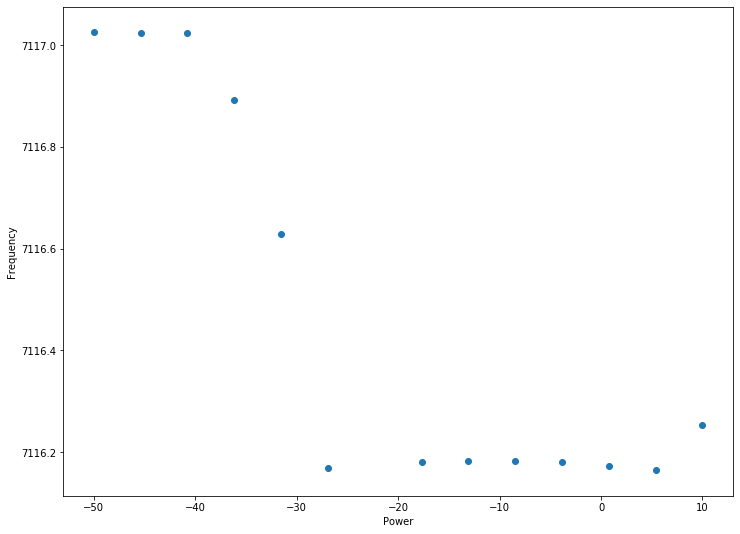

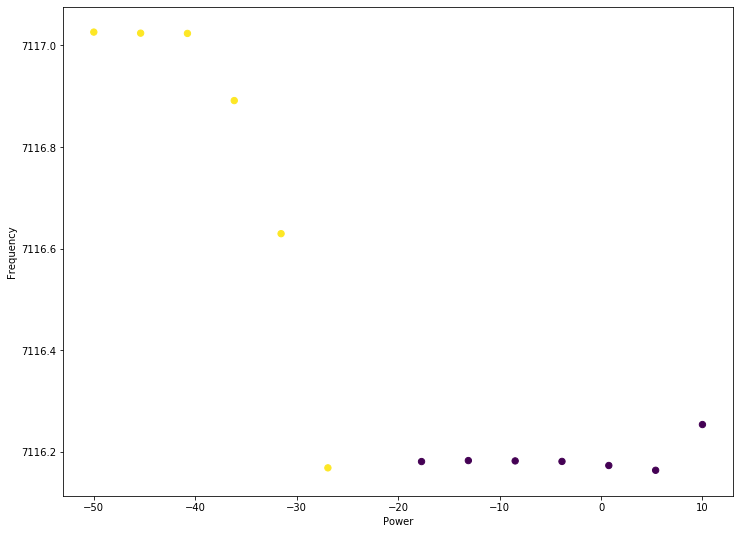

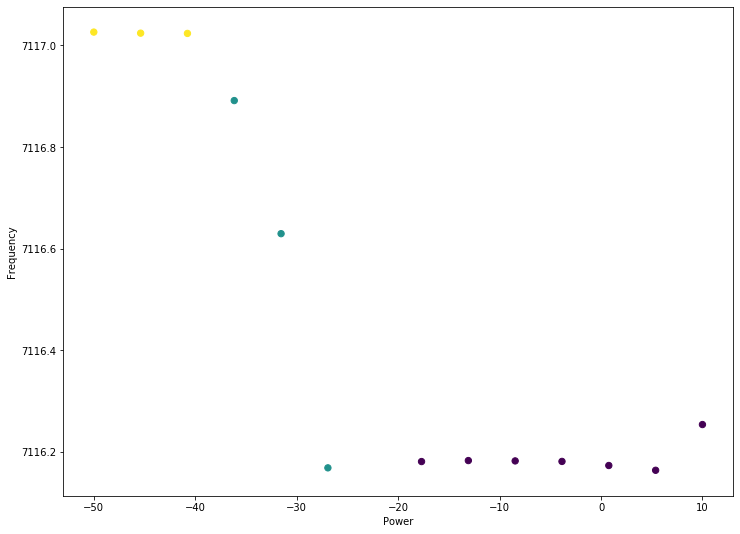

In [7]:
import matplotlib.pyplot as plt
print("start step2\n")
jobid = 5097
dataframe = Load_From_pyqum(jobid).load()
data = loadmat_valid(dataframe)
fig, ax = plt.subplots(figsize=(12, 9))
plt.scatter(data[:,0],data[:,1])
plt.xlabel("Power")
plt.ylabel("Frequency")

model = KMeans(n_clusters=2, n_init=1, random_state=0)
label = model.fit_predict(data)
fig, ax = plt.subplots(figsize=(12, 9))
plt.scatter(data[:, 0], data[:, 1], c=label, s=40)
plt.xlabel("Power")
plt.ylabel("Frequency")

label_new = outlier_detect(data,label)
fig, ax = plt.subplots(figsize=(12, 9))
plt.scatter(data[:, 0], data[:, 1], c=label_new, s=40)
plt.xlabel("Power")
plt.ylabel("Frequency")
power_0,power_1 = cloc(label_new)
select_power = min(data[:, 0][power_0],data[:, 0][power_1])
print("power : "+"{:.2f}".format(data[:, 0][power_0])+"{:<7}".format(' dBm ; ')+
      "fr : "+"{:.2f}".format(data[:, 1][power_0])+"{:<7}".format(' MHz ; \n')+
      "power : "+"{:.2f}".format(data[:, 0][power_1])+"{:<7}".format(' dBm ; ')+
      "fr : "+"{:.2f}".format(data[:, 1][power_1])+"{:<7}".format(' MHz ; '))
select_power = min(data[:, 0][power_0],data[:, 0][power_1])
print("Select Power : %f"%select_power)

In [8]:
if median(data[:, 1][label_new ==0]) > median(data[:, 1][label_new ==1]):
    print("power : "+"{:.2f}".format(data[:, 0][power_0])+"{:<7}".format(' dBm ; ')+
          "fr : "+"{:.2f}".format(data[:, 1][power_0])+"{:<7}".format(' MHz ; \n')+
          "power : "+"{:.2f}".format(data[:, 0][power_1])+"{:<7}".format(' dBm ; ')+
          "fr : "+"{:.2f}".format(data[:, 1][power_1])+"{:<7}".format(' MHz ; '))
else:
    print("power : "+"{:.2f}".format(data[:, 0][power_0])+"{:<7}".format(' dBm ; ')+
          "fr : "+"{:.2f}".format(data[:, 1][power_0])+"{:<7}".format(' MHz ; \n')+
          "power : "+"{:.2f}".format(data[:, 0][power_1])+"{:<7}".format(' dBm ; ')+
          "fr : "+"{:.2f}".format(data[:, 1][power_1])+"{:<7}".format(' MHz ; '))
select_power = min(data[:, 0][power_0],data[:, 0][power_1])

power : -17.69 dBm ; fr : 7116.18 MHz ; 
power : -40.77 dBm ; fr : 7117.02 MHz ; 


start step3

C-order : 
{'Flux-Bias': '-500e-6 to 500e-6 * 50', 'S-Parameter': 'S21,', 'IF-Bandwidth': '50', 'Power': -40, 'Frequency': '7.102 to 7.128 *200'}

Comment : 
By bot - step3 flux dependent with Cavity 7116.0 MHz

perimeter : 
{'dcsweepch': '1', 'z-idle': '{}', 'sweep-config': '{"sweeprate":0.0001,"pulsewidth":1001e-3,"current":1}', 'jobid': 5105}

C-order Data size: 
20502
Select Data length: 
20502
	Checked!

Start load data....
C-order :  ['Flux-Bias', 'S-Parameter', 'IF-Bandwidth', 'Power', 'Frequency']
Change :  ['Flux-Bias' 'Frequency']
Repeat :  []
Unchange :  ['S-Parameter' 'IF-Bandwidth' 'Power']


JOBid  5105  checked


C:\Users\tsung\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


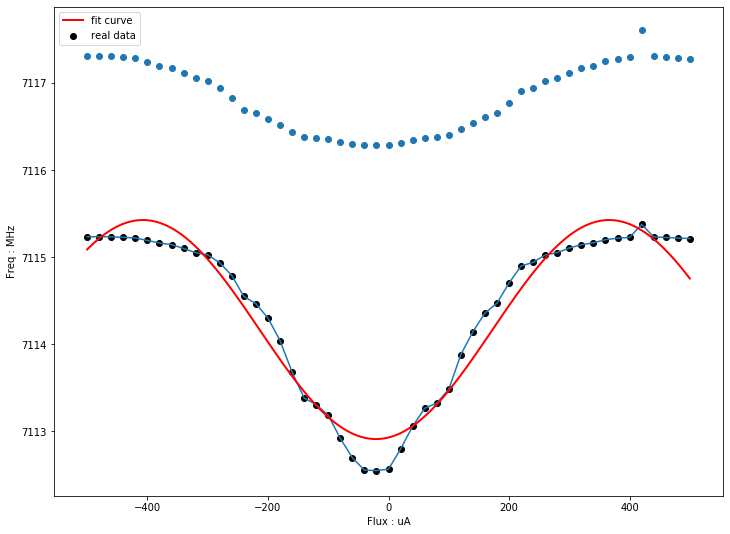

Final_dressed cavity frquency         :   7117.60 MHz
Final_bare cavity frquency            :   7116.00 MHz
Final_dressed cavity frquency diff.   :      1.60 MHz
Final_offset                          :    420.00 uA
Final_period                          :    773.79 uA


In [22]:
from numpy import linspace
cavity_list = {'7116.0 MHz': [7.102, 7.128], '6334.0 MHz': [6.32, 6.346]}
total_cavity_list =['7116.0 MHz', '6334.0 MHz']
f_bare = float(total_cavity_list[0].split(" ")[0])
print("start step3\n")
jobid = 5105
dataframe = Load_From_pyqum(jobid).load()
tol = 0.1
valid = flux_load_data(dataframe)
valid = valid.drop(valid[(valid['fr']<f_bare+tol) & (valid['fr']>f_bare-tol)].index)
ki = valid['fr']-f_bare
f_qubit = f_bare-1/ki
offset = valid['flux'][f_qubit ==f_qubit.max()]
f_dress = valid['fr'][offset.index]
fig, ax = plt.subplots(figsize=(12, 9))
plt.plot(valid['flux'],f_qubit)
plt.scatter(valid['flux'],valid['fr'])
# plt.ylim(valid['fr'].min()-.20,valid['fr'].max()+.20)

res = fit_sin(valid['flux'],f_qubit)
period = float(res['period'])
plt.rcParams["figure.figsize"] = [20,10]
plt.scatter(valid['flux'],f_qubit,color='black', marker='o',label='real data')
x = linspace(valid['flux'].min(),valid['flux'].max(),200)
plt.plot(x, res["fitfunc"](x), "r-", label="fit curve", linewidth=2)
plt.xlabel("Flux : uA")
plt.ylabel("Freq : MHz")
plt.legend()
plt.show()

print("{:<36}".format("Final_dressed cavity frquency"), " : " , "{:>8.2f}".format(float(f_dress)) ,"MHz")
print("{:<36}".format("Final_bare cavity frquency"), " : " , "{:>8.2f}".format(float(f_bare)) ,"MHz")
print("{:<36}".format("Final_dressed cavity frquency diff."), " : " , "{:>8.2f}".format(float(f_dress-f_bare)) ,"MHz")
print("{:<36}".format("Final_offset")," : ","{:>8.2f}".format(float(offset)),"uA")
print("{:<36}".format("Final_period")," : ","{:>8.2f}".format(float(period)),"uA")
    #     if plot:
    #         import matplotlib.pyplot as plt
    #         from numpy import linspace
    #         plt.rcParams["figure.figsize"] = [20,10]
    #         plt.subplot(211)
    #         plt.scatter(self.valid['flux'],self.valid['fr'],color='black', marker='o',label='real data')
    #         plt.subplot(212)
    #         plt.scatter(self.valid['flux'],f_qubit,color='r', marker='*',label='f_qubit')
    #         x = linspace(self.valid['flux'].min(),self.valid['flux'].max(),200)
    #         plt.plot(x, res["fitfunc"](x), "r-", label="fit curve", linewidth=2)
    #         plt.xlabel("Flux : uA")
    #         plt.ylabel("Freq : MHz")
    #         # plt.ylim(self.valid['fr'].min()-.20,self.valid['fr'].max()+.20)
    #         plt.legend()
    #         plt.show()
wave = {"f_dress":float(f_dress/1000),"f_bare":float(f_bare/1000),"f_diff":float((f_dress-f_bare)/1000),"offset":float(offset),"period":float(period)}
    

In [9]:
cavity_list = {'7116.0 MHz': [7.102, 7.128], '6334.0 MHz': [6.32, 6.346]}
cavity_list

{'7116.0 MHz': [7.102, 7.128], '6334.0 MHz': [6.32, 6.346]}

In [16]:
list(cavity_list.keys())[0].split(" ")[0]

'7116.0'

In [17]:
dataframe = Load_From_pyqum(jobid).load()
dataframe

C-order : 
{'Flux-Bias': '0', 'S-Parameter': 'S21,', 'IF-Bandwidth': '50', 'Power': '-50 to 10 * 13', 'Frequency': '7.102 to 7.128 *200'}

Comment : 
By bot - step2 power dependentwith Cavity 7116.0 MHz
Update: T6=10.0732mK, REF#5096

perimeter : 
{'dcsweepch': '1', 'z-idle': '{}', 'sweep-config': '{"sweeprate":0.0001,"pulsewidth":1001e-3,"current":0}', 'jobid': 5097}

C-order Data size: 
5628
Select Data length: 
5628
	Checked!

Start load data....
C-order :  ['Flux-Bias', 'S-Parameter', 'IF-Bandwidth', 'Power', 'Frequency']
Change :  ['Power' 'Frequency']
Repeat :  []
Unchange :  ['Flux-Bias' 'S-Parameter' 'IF-Bandwidth']


JOBid  5097  checked


,Power,Frequency,I,Q,Amp
0,-50.0,7.10200,-0.013531,0.412112,0.412334
1,-50.0,7.10213,0.010303,0.408311,0.408441
2,-50.0,7.10226,0.028297,0.402139,0.403133
3,-50.0,7.10239,0.050734,0.410987,0.414107
4,-50.0,7.10252,0.076738,0.400571,0.407855
...,...,...,...,...,...
2809,10.0,7.12748,-0.406683,-0.100166,0.418837
2810,10.0,7.12761,-0.411644,-0.077440,0.418865
2811,10.0,7.12774,-0.415299,-0.054444,0.418852
2812,10.0,7.12787,-0.417697,-0.031306,0.418869


In [20]:
freq = dataframe['Frequency'].to_numpy()
freq

array([7.102  , 7.10213, 7.10226, ..., 7.12774, 7.12787, 7.128  ])

In [24]:
total_cavity_list =['7116.0 MHz', '6334.0 MHz']
f_bare = float(total_cavity_list[0].split(" ")[0])
f_bare

7116.0

In [25]:
f_bare/1000

7.116

In [27]:
"{} to {} * 400".format(f_bare/1000-1,f_bare/1000+1)

'6.116 to 8.116 * 400'